### Analyzing with more and more data

In [1]:
# reload magic
%load_ext autoreload
%autoreload 2

In [2]:
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np

from mldec.datasets import toy_problem_data, toric_code_data
from mldec.models import baselines
from mldec.utils import evaluation

In [3]:
# ORIGINAL 10000 TRAIN
target_var1 = "toric-code-var-exp-v2/transformer_toric_code_results.csv"
target_var2 = "toric-code-var-exp-v2.1/transformer_toric_code_results.csv"
df_var1 = pd.read_csv(target_var1)
df_var2 = pd.read_csv(target_var2)
df_var_original = pd.concat([df_var1, df_var2] , ignore_index=True)
target_novar1 = "toric-code-novar-exp-v2/transformer_toric_code_results.csv"
target_novar2 = "toric-code-novar-exp-v2.1/transformer_toric_code_results.csv"
df_novar1 = pd.read_csv(target_novar1)
df_novar2 = pd.read_csv(target_novar2)
df_novar_original = pd.concat([df_novar1, df_novar2], ignore_index=True)

In [6]:
#  DATA SWEEEP APRIL 11.A EXPERIMENT
# beta =[1, 1.75], var
target_var1 = "toric-code-var-exp-v3.1-datasweep/transformer_toric_code_results.csv"
df_var = pd.read_csv(target_var1)

# beta=[1, 1.75], novar
target_novar1 = "toric-code-novar-exp-v3.1-datasweep/transformer_toric_code_results.csv"
df_novar = pd.read_csv(target_novar1)

# beta=3.25, novar
target_novar2 = "toric-code-novar-exp-v3.2-datasweep/transformer_toric_code_results.csv"
df_novar2 = pd.read_csv(target_novar2)
# combine df_novar2 into df_novar
df_novar = pd.concat([df_novar, df_novar2], ignore_index=True)


In [7]:
def ana_by_batch_size(df, col_name, quantile, append_inf=True):
    """For each value of batch_size, compute median and upper/lower quantile of df[col_name]."""
    batch_sizes = df['batch_size'].unique()
    # move 1994 to the end
    batch_sizes = np.array(list(sorted([x for x in batch_sizes if x != 1994])))
    if append_inf:
        batch_sizes = np.concatenate([batch_sizes, [1994]])
    medians = []
    lower_q = []
    upper_q = []
    for bs in batch_sizes:
        vals = 1 - df[df['batch_size'] == bs][col_name]
        medians.append(np.median(vals))
        lower_q.append(np.quantile(vals, 1-quantile))
        upper_q.append(np.quantile(vals, quantile))
    medians = np.array(medians)
    lower_q = medians - np.array(lower_q)
    upper_q = np.array(upper_q) - medians
    bounds = np.array(list(zip(lower_q, upper_q))).T
    return batch_sizes, medians, bounds

def ana_single_batch_size(df, col_name, quantile, batch_size):
    # add a single batch_size column to df
    df["batch_size"] = batch_size
    return ana_by_batch_size(df, col_name, quantile, append_inf=False)

quantile = 0.9
batch_sizes, medians_beta1, bounds_beta1 = ana_by_batch_size(df_var[df_var["beta"] == 1], "val_acc", quantile)
batch_sizes, medians_beta175, bounds_beta175 = ana_by_batch_size(df_var[df_var["beta"] == 1.75], "val_acc", quantile)
batch_sizes, medians_beta1_novar, bounds_beta1_novar = ana_by_batch_size(df_novar[df_novar["beta"] == 1], "val_acc", quantile)
batch_sizes, medians_beta175_novar, bounds_beta175_novar = ana_by_batch_size(df_novar[df_novar["beta"] == 1.75], "val_acc", quantile)
batch_sizes, medians_beta325_novar, bounds_beta325_novar = ana_by_batch_size(df_novar[df_novar["beta"] == 3.25], "val_acc", quantile)

In [16]:
_, medians_beta1_original, bounds_beta1_original = ana_single_batch_size(df_var_original[df_var_original["beta"] == 1], "val_acc", quantile, 10000)
_, medians_beta175_original, bounds_beta175_original = ana_single_batch_size(df_var_original[df_var_original["beta"] == 1.75], "val_acc", quantile, 10000)
_, medians_beta1_novar_original, bounds_beta1_novar_original = ana_single_batch_size(df_novar_original[df_novar_original["beta"] == 1], "val_acc", quantile, 10000)
_, medians_beta175_novar_original, bounds_beta175_novar_original = ana_single_batch_size(df_novar_original[df_novar_original["beta"] == 1.75], "val_acc", quantile, 10000)
_, medians_beta325_novar_original, bounds_beta325_novar_original = ana_single_batch_size(df_novar_original[df_novar_original["beta"] == 3.25], "val_acc", quantile, 10000)


C:\Users\peter\AppData\Local\Temp\ipykernel_19908\1258591693.py:24: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df["batch_size"] = batch_size


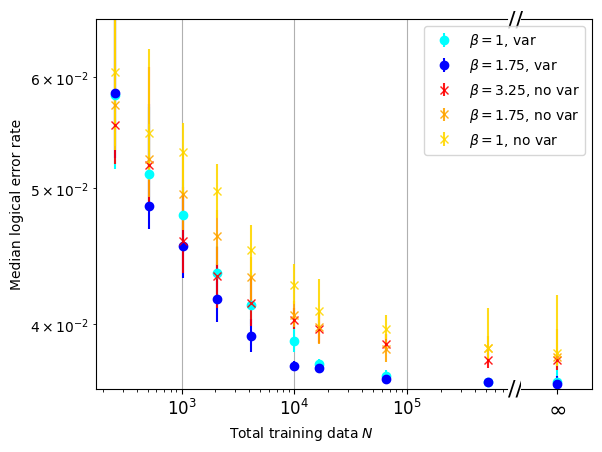

In [32]:
# close all figures
plt.close('all')
# define a gridspec
from matplotlib import gridspec
gs = gridspec.GridSpec(1, 6)
ax = plt.subplot(gs[0, :5])
ax2 = plt.subplot(gs[0, 5])

# define three shades of red: (pink, red, dark red)
red_rgb = "gold"
red_rgb2 = "orange"
red_rgb3 = "red"

novar_marker="x"
novar_alpha = 0.9

n_batches = 32 # the total training data is this time n_batches
ax.errorbar(batch_sizes[:-1] * n_batches, medians_beta1[:-1], yerr=bounds_beta1[:,:-1], fmt='o', c='cyan')
ax.errorbar(batch_sizes[:-1] * n_batches, medians_beta175[:-1], yerr=bounds_beta175[:,:-1], fmt='o', c='b')
ax.errorbar(batch_sizes[:-1] * n_batches, medians_beta325_novar[:-1], yerr=bounds_beta325_novar[:,:-1], fmt=novar_marker, c=red_rgb3, alpha=novar_alpha)
ax.errorbar(batch_sizes[:-1] * n_batches, medians_beta175_novar[:-1], yerr=bounds_beta175_novar[:,:-1], fmt=novar_marker, c=red_rgb2, alpha=novar_alpha)
ax.errorbar(batch_sizes[:-1] * n_batches, medians_beta1_novar[:-1], yerr=bounds_beta1_novar[:,:-1], fmt=novar_marker, c=red_rgb, alpha=novar_alpha)

ax.annotate('//', xy=(1.02, 0),  xycoords='axes fraction', ha='center', va='center', fontsize=16)
ax.annotate('//', xy=(1.02, 1),  xycoords='axes fraction', ha='center', va='center', fontsize=16)

# also plot original data
ax.errorbar(10000, medians_beta1_original[-1], yerr=bounds_beta1_original[:,-1].reshape(2,1), fmt='o', c='cyan')
ax.errorbar(10000, medians_beta175_original[-1], yerr=bounds_beta175_original[:,-1].reshape(2,1), fmt='o', c='b')
ax.errorbar(10000, medians_beta325_novar_original[-1], yerr=bounds_beta325_novar_original[:,-1].reshape(2,1), fmt=novar_marker, c=red_rgb3, alpha=novar_alpha)
ax.errorbar(10000, medians_beta175_novar_original[-1], yerr=bounds_beta175_novar_original[:,-1].reshape(2,1), fmt=novar_marker, c=red_rgb2, alpha=novar_alpha)
ax.errorbar(10000, medians_beta1_novar_original[-1], yerr=bounds_beta1_novar_original[:,-1].reshape(2,1), fmt=novar_marker, c=red_rgb, alpha=novar_alpha)

ax.loglog()
ax.spines[['right']].set_visible(False)
ax.set_ylim(3.6e-2, 6.6e-2)
ax.grid(axis='both')
ax.set_xlabel(r"Total training data $N$")
ax.set_ylabel(r"Median logical error rate")
# change xticklabel sizes
ax.tick_params(axis='x', labelsize=12)
# put annotated '//' at y=0, x=xlim[1] in axis coordinates

ax2.errorbar(1, medians_beta1[-1], yerr=bounds_beta1[:,-1].reshape(2,1), fmt='o', c='cyan', label=r'$\beta=1$, var')
ax2.errorbar(1, medians_beta175[-1], yerr=bounds_beta175[:,-1].reshape(2,1), fmt='o', c='b', label=r'$\beta=1.75$, var')
ax2.errorbar(1, medians_beta325_novar[-1], yerr=bounds_beta325_novar[:,-1].reshape(2,1), fmt=novar_marker, c=red_rgb3, label=r'$\beta=3.25$, no var', alpha=novar_alpha)
ax2.errorbar(1, medians_beta175_novar[-1], yerr=bounds_beta175_novar[:,-1].reshape(2,1), fmt=novar_marker, c=red_rgb2, label=r'$\beta=1.75$, no var', alpha=novar_alpha)
ax2.errorbar(1, medians_beta1_novar[-1], yerr=bounds_beta1_novar[:,-1].reshape(2,1), fmt=novar_marker, c=red_rgb, label=r'$\beta=1$, no var', alpha=novar_alpha)
ax2.spines[['left']].set_visible(False)


# suppress y-axis on ax2 and ticks
ax2.set_yticklabels([])
ax2.set_yticks([])
ax2.set_xticks([1])
ax2.set_xticklabels([r"$\infty$"], fontsize=16)
ax2.set_ylim(ax.get_ylim())

ax2.legend()


Commentary:
 - In the regime of insufficient data (less than 10000 training data), you can accomplish var, beta=1 accuracies with about 1/2 the data (var, beta=1.75) or twice the data (novar, beta=1.75)
 - This is a plot of median error vs n_train, with fixed training steps